In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

pi = np.pi

> In this notebook, I'll reproduce an optimal control problem solved in the article 'Temporal Discounting of Reward and the Cost of Time in Motor Control', published in 2010 by Shadmehr, Orban de Xivry, Wilson & Shih. The idea is to study saccade movements of the eyes. The plant is modelled as:

$$\begin{pmatrix}
\dot{x}_1 \\
\dot{x}_2 \\
\dot{x}_3
\end{pmatrix} = \begin{pmatrix}
0 & 1 & 0 \\
-\frac{k}{m} & -\frac{b}{m} & \frac{1}{m}\\
0 & 0 & -\frac{\alpha_2}{\alpha_1}
\end{pmatrix}\begin{pmatrix}
x_1\\
x_2\\
x_3
\end{pmatrix}+\begin{pmatrix}0\\0\\ \frac{1}{\alpha_1}
\end{pmatrix} u$$

> The cost that we want to minimize can be written as:
$$J = (\textbf{x}^{(p)}-\textbf{r})^T T (\textbf{x}^{(p)}-\textbf{r}) + \textbf{u}_h^T L \textbf{u}_h + \alpha  p^2$$

> In order to minimize this cost, we must first select an arbitrary length of time $p$ and find the optimal set of motor commandes $\textbf{u}^*_h(p)$ that minimize $J$. The solution is given as:

$$\textbf{u}_h^*(p) = (L+\Gamma^T F^T C^T T C F \Gamma)^{-1}\Gamma^T F^T C^T T(\textbf{r}_h-C A^p \textbf{x}^{(0)})$$

>  Finally, we can use the following discrete equation to find the velocity profile for each time duration:

$$\textbf{x}^{(k)}=A^k \textbf{x}^{(0)}+\sum_{j=0}^{k-1}A^{k-1-j}\textbf{b}u^{(j)}$$

> At the final state:

$$\textbf{x}^{(p)}=A^p \textbf{x}^{(0)}+\sum_{k=0}^{p-1}A^{p-1-k}\textbf{b}u^{(k)}=A^p \textbf{x}^{(0)}+F \Gamma \textbf{u}_h$$

> We can introduce the following matrices:
$$F = \begin{pmatrix}
A^{p-1} & A^{p-2} & ... & A & I\\ 
\end{pmatrix}$$


$$\Gamma = \begin{pmatrix}
\textbf{b} & 0 & ... & 0 \\
0 & \textbf{b} & ... & 0 \\
\vdots & 0 & \ddots & \vdots \\
0 & 0 & ... & \textbf{b}
\end{pmatrix}$$

> We can plug this into equation (.):

$$J(p) = \left(A^p \textbf{x}^{(0)}+F \Gamma \textbf{u}_h-\textbf{r}\right)^T T \left(A^p \textbf{x}^{(0)}+F \Gamma \textbf{u}_h-\textbf{r}\right) + \textbf{u}_h^T L \textbf{u}_h + \alpha  p^2$$

> And minimize with respect to $\textbf{u}_h$:

$$\frac{dJ}{d\textbf{u}_h} = 2\Gamma^T F^T T A^p \textbf{x}^{(0)}+2 \Gamma^T F^T T F \Gamma \textbf{u}_h-2 \Gamma^T F^T T \textbf{r}+2 L \textbf{u}_h$$

$$\textbf{u}_h^*(p) = (L+\Gamma^T F^T  T  F \Gamma)^{-1}\Gamma^T F^T  T(\textbf{r}-A^p \textbf{x}^{(0)})$$

In [11]:
# DEFINITIONS OF CONSTANTS AND MATRICES

k=1.0
tau1=0.224
tau2=0.013
b=tau1+tau2
m=tau1*tau2
alpha2=1.0
alpha1=0.004
nu1=5.0E9
nu2=1.0E6
nu3=80.0
kappa=0.009
dt=1.0E-03

T = [[nu1,0,0],
     [0,nu2,0],
     [0,0,nu3]]

x0 = [[0],    #initial state
      [0],
      [0]]

A  = [[0,1,0],    
      [-k/m,-b/m,1/m],
      [0,0,-alpha2/alpha1]]

A = np.multiply(A,dt)+np.identity(3)

B  = [[0],
      [0],
      [1/alpha1]]

B  = np.multiply(B,dt) 

def rmatrix(amp):
    '''This function defines matrix r for a given amplitude 'amp' (degree)'''
    r = [[amp*pi/180],[0],[0]]
    return(np.asarray(r))

def Fmatrix(p):
    '''This function defines matrix F'''
    F=[]
    for t in range(0,p):
        F.insert(0,np.linalg.matrix_power(A,t))
    F=np.block(F)
    return(F)

def Gmatrix(p):
    return(np.kron(np.eye(p), B))


def uopt(p,amp):
    '''This function computes the optimal control for a saccade duration 'p' and
    an amplitude 'amp' (w/o noise)'''
    F=Fmatrix(p)
    G=Gmatrix(p)
    r=rmatrix(amp)
    GFTrans=np.matmul(G.transpose(),F.transpose())
    GFT=np.matmul(GFTrans,T)
    FG=np.matmul(F,G)
    GFTFG=np.matmul(GFT,FG)
    Inv=np.linalg.inv(np.identity(p)+GFTFG)
    InvGFT=np.matmul(Inv,GFT)
    Apx0=np.matmul(np.linalg.matrix_power(A,p),x0)
    u=np.matmul(InvGFT,r-Apx0)
    return(u)

def velocityopt(p,amp):
    '''Optimal velocity computed from the optimal control w/o noise.'''
    u=uopt(p,amp)
    velocity=[]
    for k in range(0,p):
        summ=0
        for j in range(0,k):
            summ+=np.matmul(np.linalg.matrix_power(A,k-1-j),B)*u[j,0]
        xk=np.matmul(np.linalg.matrix_power(A,k),x0)+summ
        velocity.append(xk[1,0])
    vdeg=[v*180/pi for v in velocity]
    return(vdeg)

#### FUNCTIONS WITH NOISE


def uoptn(p,amp):
    '''This function computes the optimal control for a saccade duration 'p' and
    an amplitude 'amp' (with noise)'''
    #REQUIRED MATRICES
    u=uopt(p,amp)
    F=Fmatrix(p)
    G=Gmatrix(p)
    r=rmatrix(amp)
    #COMPUTATION OF U*
    GFTrans=np.matmul(G.transpose(),F.transpose())
    GFT=np.matmul(GFTrans,T)
    FG=np.matmul(F,G)
    GFTFG=np.matmul(GFT,FG)
    S = np.diag(GFTFG)
    S = np.diag(S)
    Inv=np.linalg.inv(np.identity(p)+GFTFG+np.multiply(kappa**2,S))
    InvGFT=np.matmul(Inv,GFT)
    Apx0=np.matmul(np.linalg.matrix_power(A,p),x0)
    u=np.matmul(InvGFT,r-Apx0)
    return(u)

def epsilon(p,amp):
    eps=[]
    u=uoptn(p,amp)
    for k in range(0,p):
        epsk =(1/(np.sqrt(2*pi)*kappa*u[k,0])*np.exp(-(k*dt)**2/(2*kappa**2*u[k,0]**2)))
        eps.append(epsk)
    epsilon=np.reshape(eps,(len(eps),1))
    return(epsilon)


def velocityoptn(p,amp):
    '''Optimal velocity computed from optimal control with noise.'''
    u=uoptn(p,amp)
    eps=epsilon(p,amp)
    velocity=[]
    xk=x0   
    for k in range(0,p):
        summ=0
        for j in range(0,k):
            summ+=np.matmul(np.linalg.matrix_power(A,k-1-j),B)*u[j,0]
        xk=np.matmul(np.linalg.matrix_power(A,k),x0)+summ
        velocity.append(xk[1,0])
    vdeg=[v*180/pi for v in velocity]
    return(vdeg)


### COST FUNCTIONS

def costeffort(pmin,pmax,amp):
    '''This function computes the physical effort, using the optimal control (with noise).'''
    costeffort=[]
    summ=0
    for k in range(pmin,pmax):
        u=uoptn(k,amp)
        mprod=np.matmul(u.transpose(),u)
        costeffort.append(mprod[0,0])
    return(costeffort)

def costoftime(pmin,pmax,amp):
    '''This function computes a cost of time quadratic in the saccade duration.'''
    costoftime=[]
    alpha=5.75E04
    for k in range(pmin,pmax):
        costoftime.append(alpha*(k*dt)**2)
    return(costoftime)


def Umatrix(p,amp):
    '''This function generates a square matrix with the components of the optimal control u(p)
    on the diagonal.'''
    u=uoptn(p,amp)
    U=np.zeros((np.shape(u)[0],np.shape(u)[0]))
    for i in range(np.shape(u)[0]):
        U[i,i]=u[i]
    return(U)

def finalstate(p,amp):
    '''This function computes the final state using u*(p) with noise.'''
    u=uoptn(p,amp)
    eps=epsilon(p,amp)
    summ=0
    for k in range(0,p):
        ab=np.matmul(np.linalg.matrix_power(A,p-1-k),B)
        abu=np.multiply(ab,u[k,0]+eps[k,0])
        summ+=abu
    xp=np.matmul(np.linalg.matrix_power(A,p),x0)+summ
    return(xp)

def accuracycost(pmin,pmax,amp):
    '''This function computes the accuracy cost.'''
    accuracycost=[]
    summ=0
    r=rmatrix(amp)
    for k in range(pmin,pmax):
        F=Fmatrix(k)
        G=Gmatrix(k)
        U=Umatrix(k,amp)
        u=uoptn(k,amp)
        xp=finalstate(k,amp)
        xexpected=np.matmul(np.linalg.matrix_power(A,k),x0)+np.matmul(np.matmul(F,G),u)
        varxp=np.multiply(kappa**2,np.matmul(np.matmul(np.matmul(F,G),np.linalg.matrix_power(U,2)),np.matmul(F,G).transpose()))
        XTX=np.matmul(np.matmul(xexpected.transpose(),T),xexpected) 
        trace=np.trace(np.matmul(T,varxp))
        XTr=np.matmul(np.matmul(xexpected.transpose(),T),r)
        rTr=np.matmul(np.matmul(r.transpose(),T),r) 
        accuracycost.append((XTX+trace-2*XTr+rTr)[0,0])
    return(accuracycost)


### OPTIMAL SACCADE DURATION  !!TIME CONSUMING!!

def optimaltime(pmin,pmax,amp):
    physeff=costeffort(pmin,pmax,amp)
    CoT=costoftime(pmin,pmax,amp)
    accuracy=accuracycost(pmin,pmax,amp)
    totalcost = [sum(x) for x in zip(physeff,CoT,accuracy)]
    time=np.linspace(pmin,pmax,pmax-pmin)
    plt.plot(time,totalcost,label=r'$\theta = $'+str(amp)+'°')
    return(np.argmin(totalcost))
    

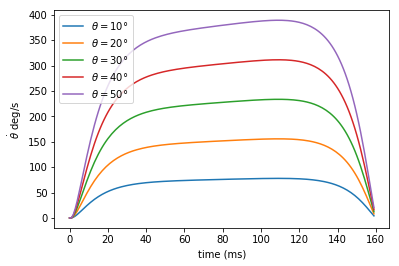

In [12]:
p=160

amp=[10,20,30,40,50]

for a in amp:
    plt.plot(velocityopt(p,a),label=r'$\theta = $'+str(a)+'°')


plt.xlabel('time (ms)')
plt.ylabel(r'$\dot{\theta}$ deg/s')
plt.legend()
plt.show()

# Adding some noise (and some trouble)

> Now we must consider some Gaussian noise $\varepsilon^{(k)} = \mathcal{N}\left[0,\kappa^2 \left(u^{(k)}\right)^2\right]=\frac{1}{\sqrt{2\pi}\kappa u^{(k)}}e^{-\frac{k^2}{2\kappa^2 u^{2}}}$.

$$\textbf{x}^{(k+1)}=A \textbf{x}^{(k)}+\textbf{b}\left(u^{(k)}+\varepsilon^{(k)}\right)$$

$$\textbf{u}_h^*(p) = \left(L+\Gamma^T F^T T F \Gamma +\kappa^2 S\right)^{-1}\Gamma^T F^T T \left(\textbf{r}-A^{(p)}\textbf{x}^{(0)}\right)$$

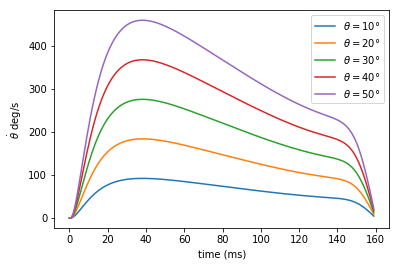

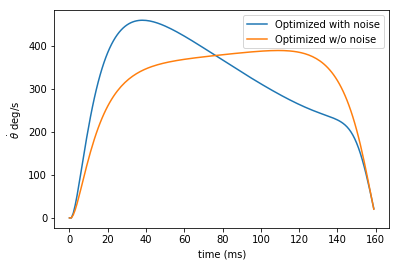

In [13]:
p=160

amp=[10,20,30,40,50]
for a in amp:
    plt.plot(velocityoptn(p,a),label=r'$\theta = $'+str(a)+'°')

plt.xlabel('time (ms)')
plt.ylabel(r'$\dot{\theta}$ deg/s')
plt.legend()
plt.show()

plt.plot(velocityoptn(p,50),label='Optimized with noise')
plt.plot(velocityopt(p,50),label='Optimized w/o noise')
plt.xlabel('time (ms)')
plt.ylabel(r'$\dot{\theta}$ deg/s')
plt.legend()
plt.show()


# Compute the costs

> We can now evaluate separately $J_x = E\left[\left(\textbf{x}^{(p)}-\textbf{r}\right)^T T \left(\textbf{x}^{(p)}-\textbf{r}\right)\right]$, $J_u = (\textbf{u}_h^*)^T L \textbf{u}_h^*$ and $J_p = \alpha p^2$.

> The state at the end of the movement is:
$$\textbf{x}^{(p)}=A^p \textbf{x}^{(0)}+F\Gamma (\textbf{u}_h + \varepsilon_h)$$
$$E\left[\textbf{x}^{(p)}\right]=A^p \textbf{x}^{(0)}+F\Gamma\textbf{u}_h$$
$$\textrm{var}\left[\textbf{x}^{(p)}\right]=\kappa^2 F \Gamma U U \Gamma^T F^T$$
>Eventually, $J_x$ can be written as:
$$J_x = E\left[\textbf{x}^{(p)}\right]^T T E\left[\textbf{x}^{(p)}\right]+tr\left[T \textrm{var}\left[\textbf{x}^{(p)}\right]\right]-2E\left[\textbf{x}^{(p)}\right]^T T \textbf{r}+\textbf{r}^T T \textbf{r}$$

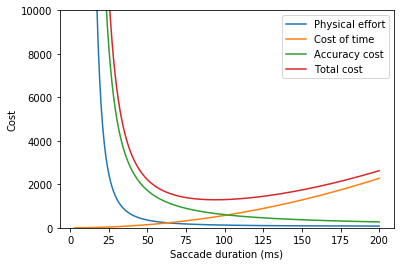

In [5]:
pmin=3
pmax=200
amp=20.0

physeff=costeffort(pmin,pmax,amp)
CoT=costoftime(pmin,pmax,amp)
accuracy=accuracycost(pmin,pmax,amp)
totalcost = [sum(x) for x in zip(physeff,CoT,accuracy)]

time=np.linspace(pmin,pmax,pmax-pmin)
plt.plot(time,physeff,label='Physical effort')
plt.plot(time,CoT,label='Cost of time')
plt.plot(time,accuracy,label='Accuracy cost')
plt.plot(time,totalcost,label='Total cost')
plt.legend()
plt.xlabel('Saccade duration (ms)')
plt.ylabel('Cost')
axes = plt.gca()
axes.set_ylim([0,10000])
plt.show()

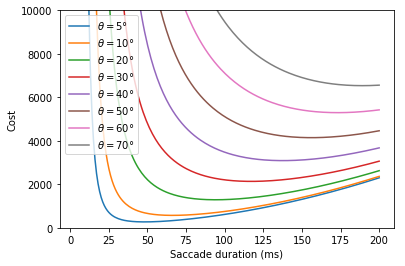

Optimal duration =  [45, 63, 91, 114, 134, 152, 169, 185]


In [6]:
amp=[5,10,20,30,40,50,60,70]
timep=[]
for a in amp:
    timep.append(optimaltime(3,200,a))

plt.legend()
plt.xlabel('Saccade duration (ms)')
plt.ylabel('Cost')
axes = plt.gca()
axes.set_ylim([0,10000])
plt.savefig("totcosts.pdf", bbox_inches='tight')
plt.show()
    
print("Optimal duration = ",timep)

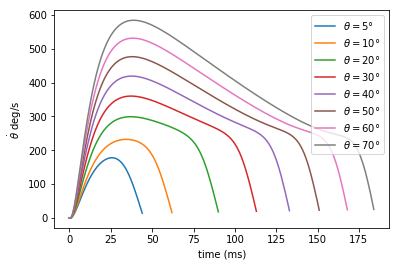

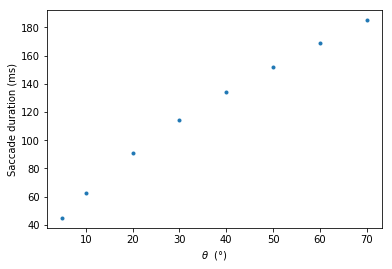

In [7]:
for i in range(len(timep)):
    plt.plot(velocityoptn(timep[i],amp[i]),label=r'$\theta = $'+str(amp[i])+'°')
plt.xlabel('time (ms)')
plt.ylabel(r'$\dot{\theta}$ deg/s')
plt.legend()
plt.show()

plt.plot(amp,timep,'.')
plt.xlabel(r'$\theta$  (°)')
plt.ylabel('Saccade duration (ms)')
plt.savefig("duration_amplitude.pdf", bbox_inches='tight')
plt.show()